
**Agricultura e Desenvolvimento Humano: Uma Análise de Correlação entre a Produção Agrícola e o IDHM no Brasil**


O objetivo desse trabalho é analisar os dados de produção agrícola bruta de cada município brasileiro, buscando entender se o mesmo impacta de alguma forma o IDHM (Índice de Desenvolvimento Humano Municipal), que é uma média composta pelos indicadores de três dimensões do desenvolvimento humano: educação, renda e longevidade.
Utilizaremos modelos de Machine Learning que terá o objetivo de checar se há algum impacto da produção agrícola no IDH dos municípios brasileiros.

---



In [1]:
#Instalando os complementos necessários
!pip install seaborn -q
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 3.2 MB/s eta 0:00:00


In [2]:
#Importando as bibliotecas necessarias para a realização do trabalho
import requests as r
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
from statistics import mean
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score, f1_score, \
precision_score, recall_score, roc_auc_score, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, \
StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from category_encoders import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [3]:
#Conectando ao Google Drive para acessar a base de dados.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [4]:
#Removendo UF do nome do município.
#Abrindo o arquivo Excel
workbook = openpyxl.load_workbook(r"/content/drive/MyDrive/TCC2023/Excel/IDH2010AB.xlsx")

#Selecionando a Planilha
worksheet = workbook['Worksheet']

#Iterando pelas células na coluna A a partir da segunda linha pois a primeira é o cabeçalho
for row in worksheet.iter_rows(min_row=2, min_col=1):
    cell = row[0]
    # obtém o valor da célula como uma string
    value = str(cell.value)
    # remove as cinco últimas letras da string
    new_value = value[:-5]
    # atualiza o valor da célula com a nova string
    cell.value = new_value

#Salvando o arquivo Excel com as alterações
workbook.save(r"/content/drive/MyDrive/TCC2023/Excel/IDH2010AB_C.xlsx")


In [5]:
#Carregando a planilha como DataFrame
IDH = (r"/content/drive/MyDrive/TCC2023/Excel/IDH2010AB_C.xlsx")
idh_df = pd.read_excel(IDH)
idh_df.head()
idh_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5565 entries, 0 to 5564
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Municipio                 5565 non-null   object 
 1   Posição IDHM              5565 non-null   int64  
 2   IDHM                      5565 non-null   float64
 3   Posição IDHM Renda        5565 non-null   int64  
 4   IDHM Renda                5565 non-null   float64
 5   Posição IDHM Educação     5565 non-null   int64  
 6   IDHM Educação             5565 non-null   float64
 7   Posição IDHM Longevidade  5565 non-null   int64  
 8   IDHM Longevidade          5565 non-null   float64
dtypes: float64(4), int64(4), object(1)
memory usage: 391.4+ KB


In [6]:
"""A planilha com dados mais atualizados de IDH é de 2010 disponível no atlas brasil.
Já as planilhas de produtividade por cultura são entre o período de 2017 a 2020."""

#Checando se a planilha foi carregada corretamente e os dados disponíveis nela.
idh_df.head()

,Municipio,Posição IDHM,IDHM,Posição IDHM Renda,IDHM Renda,Posição IDHM Educação,IDHM Educação,Posição IDHM Longevidade,IDHM Longevidade
0,São Caetano do Sul,1,0.862,1,0.891,2,0.811,19,0.887
1,Águas de São Pedro,2,0.854,12,0.849,1,0.825,11,0.890
2,Florianópolis,3,0.847,5,0.870,5,0.800,147,0.873
3,Vitória,4,0.845,3,0.876,4,0.805,551,0.855
4,Balneário Camboriú,4,0.845,10,0.854,6,0.789,1,0.894


In [7]:
#Obtendo uma visão geral do DataFrame. Assim é possivel analisar o número de linhas e colunas, a quantidade de valores não nulos em cada coluna e o tipo de dado armazenado em cada coluna.
idh_df
print(idh_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5565 entries, 0 to 5564
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Municipio                 5565 non-null   object 
 1   Posição IDHM              5565 non-null   int64  
 2   IDHM                      5565 non-null   float64
 3   Posição IDHM Renda        5565 non-null   int64  
 4   IDHM Renda                5565 non-null   float64
 5   Posição IDHM Educação     5565 non-null   int64  
 6   IDHM Educação             5565 non-null   float64
 7   Posição IDHM Longevidade  5565 non-null   int64  
 8   IDHM Longevidade          5565 non-null   float64
dtypes: float64(4), int64(4), object(1)
memory usage: 391.4+ KB
None


In [8]:
#Filtrando as colunas de interesse.
idh_df.loc[:, 'Municipio'] = idh_df['Municipio'].str.title()
idhf_df=idh_df[['Municipio','IDHM']]
idhf_df.head()

,Municipio,IDHM
0,São Caetano Do Sul,0.862
1,Águas De São Pedro,0.854
2,Florianópolis,0.847
3,Vitória,0.845
4,Balneário Camboriú,0.845


In [9]:
idhf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5565 entries, 0 to 5564
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Municipio  5565 non-null   object 
 1   IDHM       5565 non-null   float64
dtypes: float64(1), object(1)
memory usage: 87.1+ KB


In [10]:
#Carregando o Dataframe com os dados de produção da Soja
soja = (r"/content/drive/MyDrive/TCC2023/Excel/Soja.xlsx")
soja = pd.read_excel(soja)
#Filtrando as colunas de interesse.
soja.loc[:, 'Municipio'] = soja['Municipio'].str.title()
soja_df=soja[['Municipio','Produtividade']]
soja_df.head()

,Municipio,Produtividade
0,Alta Floresta D'Oeste,1350.0
1,Ariquemes,25497.0
2,Cabixi,86772.0
3,Cacoal,3000.0
4,Cerejeiras,140760.0


In [11]:
#Carregando o Dataframe com os dados de produção do Milho
milho = (r"/content/drive/MyDrive/TCC2023/Excel/Milho.xlsx")
milho = pd.read_excel(milho)
#Filtrando as colunas de interesse.
milho.loc[:, 'Municipio'] = milho['Municipio'].str.title()
milho_df=milho[['Municipio','Produtividade']]
milho_df.head()

,Municipio,Produtividade
0,Alta Floresta D'Oeste,16267.0
1,Ariquemes,5760.0
2,Cabixi,93920.0
3,Cacoal,3616.0
4,Cerejeiras,147360.0


In [12]:
#Carregando o Dataframe com os dados de produção do Café
cafe = (r"/content/drive/MyDrive/TCC2023/Excel/Café.xlsx")
cafe = pd.read_excel(cafe)
#Filtrando as colunas de interesse.
cafe.loc[:, 'Municipio'] = cafe['Municipio'].str.title()
cafe_df=cafe[['Municipio','Produtividade']]
cafe_df.head()

,Municipio,Produtividade
0,Jussari,57
1,Alto Caparaó,3889
2,Sabará,6
3,Alta Floresta D'Oeste,4798
4,Ariquemes,294


In [13]:
#Carregando o Dataframe com os dados de produção do Trigo
trigo = (r"/content/drive/MyDrive/TCC2023/Excel/Trigo.xlsx")
trigo = pd.read_excel(trigo)
#Filtrando as colunas de interesse.
trigo.loc[:, 'Municipio'] = trigo['Municipio'].str.title()
trigo_df=trigo[['Municipio','Produtividade']]
trigo_df.head()

,Municipio,Produtividade
0,Água Fria De Goiás,7615
1,Antônio João,868
2,Victor Graeff,12356
3,Soledade,5524
4,Sertão,12463


In [14]:
#Carregando o Dataframe com os dados de produção do Algodão
algodao = (r"/content/drive/MyDrive/TCC2023/Excel/Algodão.xlsx")
algodao = pd.read_excel(algodao)
#Filtrando as colunas de interesse.
algodao.loc[:, 'Municipio'] = algodao['Municipio'].str.title()
algodao_df=algodao[['Municipio','Produtividade']]
algodao_df.head()

,Municipio,Produtividade
0,Perolândia,3553
1,Costa Rica,92603
2,Serra Talhada,2
3,Canindé,7
4,Acopiara,41


In [15]:
#Obtendo uma visão geral de cada DataFrame. Assim é possivel analisar o número de linhas e colunas, a quantidade de valores não nulos em cada coluna e o tipo de dado armazenado em cada coluna.
print(soja_df.info())
print(milho_df.info())
print(cafe_df.info())
print(trigo_df.info())
print(algodao_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2388 entries, 0 to 2387
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Municipio      2388 non-null   object 
 1   Produtividade  2388 non-null   float64
dtypes: float64(1), object(1)
memory usage: 37.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5104 entries, 0 to 5103
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Municipio      5104 non-null   object 
 1   Produtividade  5104 non-null   float64
dtypes: float64(1), object(1)
memory usage: 79.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1212 entries, 0 to 1211
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Municipio      1212 non-null   object
 1   Produtividade  1212 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 

In [16]:
# Carregando as seis planilhas do Excel em um dicionário
planilhas = {}
for cultivo in ['Soja', 'Café', 'Milho', 'Trigo', 'Algodão',]:
    planilhas[cultivo] = pd.read_excel(f"/content/drive/MyDrive/TCC2023/Excel/{cultivo}.xlsx", sheet_name='Worksheet')
    
# Selecionando apenas a coluna desejada em cada planilha e renomeiando para o nome do cultivo
colunas_selecionadas = {}
for cultivo in ['Soja', 'Café', 'Milho', 'Trigo', 'Algodão',]:
    colunas_selecionadas[cultivo] = planilhas[cultivo][['Municipio', 'Produtividade']].rename(columns={'Produtividade': cultivo})

# Unindo os dataframes usando a coluna 'Municipio' como chave de união
df_final = pd.merge(colunas_selecionadas['Soja'], colunas_selecionadas['Café'], on='Municipio', how='outer')
for cultivo in ['Milho', 'Trigo', 'Algodão']:
    df_final = pd.merge(df_final, colunas_selecionadas[cultivo], on='Municipio', how='outer')

# Salvando a nova planilha em um arquivo Excel
df_final.to_excel(r"/content/drive/MyDrive/TCC2023/Excel/Colunas_selecionadas.xlsx", index=False)

In [17]:
#Renomeando as Colunas para facil entendimento posteriormente
prod_comb = (r"/content/drive/MyDrive/TCC2023/Excel/Colunas_selecionadas.xlsx")
prod_comb_df = pd.read_excel(prod_comb)
prod_comb_df = prod_comb_df.rename(columns={'Soja': 'Prod_Soja', 'Café': 'Prod_Cafe', 'Milho': 'Prod_Milho', 'Trigo': 'Prod_Trigo', 'Algodão': 'Prod_Algodao' })
prod_comb_df.head()

,Municipio,Prod_Soja,Prod_Cafe,Prod_Milho,Prod_Trigo,Prod_Algodao
0,Alta Floresta D'Oeste,1350.0,4798.0,16267.0,NaN,NaN
1,Ariquemes,25497.0,294.0,5760.0,NaN,NaN
2,Cabixi,86772.0,1.0,93920.0,NaN,NaN
3,Cacoal,3000.0,3240.0,3616.0,NaN,NaN
4,Cerejeiras,140760.0,13.0,147360.0,NaN,NaN


In [18]:
#Criando uma coluna com a soma total das produtividades das culturas selecionadas por municipio
prod_comb_df['Total_Prod'] = prod_comb_df[['Prod_Soja', 'Prod_Cafe', 'Prod_Milho', 'Prod_Trigo', 'Prod_Algodao']].sum(axis=1)
prod_comb_df.head()

,Municipio,Prod_Soja,Prod_Cafe,Prod_Milho,Prod_Trigo,Prod_Algodao,Total_Prod
0,Alta Floresta D'Oeste,1350.0,4798.0,16267.0,NaN,NaN,22415.0
1,Ariquemes,25497.0,294.0,5760.0,NaN,NaN,31551.0
2,Cabixi,86772.0,1.0,93920.0,NaN,NaN,180693.0
3,Cacoal,3000.0,3240.0,3616.0,NaN,NaN,9856.0
4,Cerejeiras,140760.0,13.0,147360.0,NaN,NaN,288133.0


In [54]:
#Unindo o dataframe IDHM com o de Produção através da vaviável Municipio
IDHM_Prod_df = pd.merge(prod_comb_df, idhf_df, on='Municipio')

#Checando o resultado da união
IDHM_Prod_df

,Municipio,Prod_Soja,Prod_Cafe,Prod_Milho,Prod_Trigo,Prod_Algodao,Total_Prod,IDHM
0,Alta Floresta D'Oeste,1350.0,4798.0,16267.0,NaN,NaN,22415.0,0.641
1,Ariquemes,25497.0,294.0,5760.0,NaN,NaN,31551.0,0.702
2,Cabixi,86772.0,1.0,93920.0,NaN,NaN,180693.0,0.650
3,Cacoal,3000.0,3240.0,3616.0,NaN,NaN,9856.0,0.718
4,Cerejeiras,140760.0,13.0,147360.0,NaN,NaN,288133.0,0.692
...,...,...,...,...,...,...,...,...
4970,Nova Glória,NaN,NaN,4800.0,NaN,NaN,4800.0,0.681
4971,Novo Brasil,NaN,NaN,875.0,NaN,NaN,875.0,0.699
4972,Rubiataba,NaN,NaN,1000.0,NaN,NaN,1000.0,0.719
4973,São Patrício,NaN,NaN,1560.0,NaN,NaN,1560.0,0.693


In [55]:
#Detectando valores ausentes.
print(IDHM_Prod_df.isnull().sum())
print(IDHM_Prod_df.isna().sum())
print(IDHM_Prod_df.info())

Municipio          0
Prod_Soja       2125
Prod_Cafe       3448
Prod_Milho        60
Prod_Trigo      3986
Prod_Algodao    4809
Total_Prod         0
IDHM               0
dtype: int64
Municipio          0
Prod_Soja       2125
Prod_Cafe       3448
Prod_Milho        60
Prod_Trigo      3986
Prod_Algodao    4809
Total_Prod         0
IDHM               0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4975 entries, 0 to 4974
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Municipio     4975 non-null   object 
 1   Prod_Soja     2850 non-null   float64
 2   Prod_Cafe     1527 non-null   float64
 3   Prod_Milho    4915 non-null   float64
 4   Prod_Trigo    989 non-null    float64
 5   Prod_Algodao  166 non-null    float64
 6   Total_Prod    4975 non-null   float64
 7   IDHM          4975 non-null   float64
dtypes: float64(7), object(1)
memory usage: 349.8+ KB
None


In [56]:
#Convertendo os valores NaN em 0
IDHM_Prod_df.fillna(0, inplace=True)
#Detectando valores ausentes.
print(IDHM_Prod_df.isnull().sum())
print(IDHM_Prod_df.isna().sum())
print(IDHM_Prod_df.info())

Municipio       0
Prod_Soja       0
Prod_Cafe       0
Prod_Milho      0
Prod_Trigo      0
Prod_Algodao    0
Total_Prod      0
IDHM            0
dtype: int64
Municipio       0
Prod_Soja       0
Prod_Cafe       0
Prod_Milho      0
Prod_Trigo      0
Prod_Algodao    0
Total_Prod      0
IDHM            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4975 entries, 0 to 4974
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Municipio     4975 non-null   object 
 1   Prod_Soja     4975 non-null   float64
 2   Prod_Cafe     4975 non-null   float64
 3   Prod_Milho    4975 non-null   float64
 4   Prod_Trigo    4975 non-null   float64
 5   Prod_Algodao  4975 non-null   float64
 6   Total_Prod    4975 non-null   float64
 7   IDHM          4975 non-null   float64
dtypes: float64(7), object(1)
memory usage: 349.8+ KB
None


In [57]:
#Checando dados duplicados
duplicatas = IDHM_Prod_df.duplicated()
print(duplicatas.sum())  # mostra o número de linhas duplicadas
print(IDHM_Prod_df[duplicatas])  # mostra as linhas duplicadas
#Removendo dados duplicados quando são identicos nas colunas
IDHM_Prod_df.drop_duplicates(subset=['Municipio','Prod_Soja', 'Prod_Cafe', 'Prod_Milho', 'Prod_Trigo', 'Prod_Algodao'], inplace=True)
#Checando dados duplicados
duplicatas = IDHM_Prod_df.duplicated()
print(duplicatas.sum())  # mostra o número de linhas duplicadas
print(IDHM_Prod_df[duplicatas])  # mostra as linhas duplicadas

6
                 Municipio  Prod_Soja  Prod_Cafe  Prod_Milho  Prod_Trigo  \
746   Presidente Juscelino      360.0        0.0        40.0         0.0   
749   Presidente Juscelino      360.0        0.0       480.0         0.0   
752   Presidente Juscelino      360.0        0.0       945.0         0.0   
2497                Bonito   184800.0     2204.0        70.0         0.0   
2501                Bonito   184800.0     2204.0       480.0         0.0   
2505                Bonito   184800.0     2204.0    120780.0         0.0   

      Prod_Algodao  Total_Prod   IDHM  
746            0.0       400.0  0.563  
749            0.0       840.0  0.563  
752            0.0      1305.0  0.563  
2497           0.0    187074.0  0.561  
2501           0.0    187484.0  0.561  
2505           0.0    307784.0  0.561  
0
Empty DataFrame
Columns: [Municipio, Prod_Soja, Prod_Cafe, Prod_Milho, Prod_Trigo, Prod_Algodao, Total_Prod, IDHM]
Index: []


"A seguir, podemos observar as categorias sob as quais são divididos as cidades com base em seus respectivos IDHs:
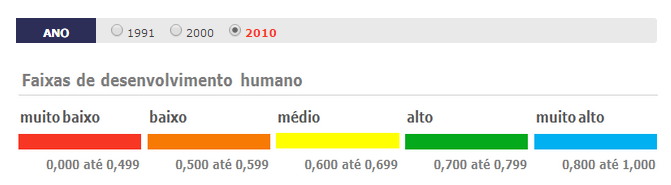

Dessa forma criei uma nova coluna, IDHM_Faixa, separando o IDHM por faixas correspondentes.

In [85]:
#Incluindo uma coluna com uma variável categórica para posterior uso no modelo Decision Tree Classifier.
dicionario_faixas  ={0: [0.0, 0.499], 1: [0.5, 0.599], 2:[0.6, 0.699], 3:[0.7,0.799], 4:[0.8,1.0]}
IDHM_Prod_df['IDHM_Faixa'] = 0
for faixa in dicionario_faixas:
  limitante = dicionario_faixas[faixa]
  IDHM_Prod_df.loc[(IDHM_Prod_df.IDHM >= limitante[0])&(IDHM_Prod_df.IDHM < limitante[1]), 'IDHM_Faixa'] = faixa
IDHM_Prod_df.loc[:, ['IDHM_Faixa','Municipio' ]].groupby(by= ['IDHM_Faixa']).count()
IDHM_Prod_df

,Municipio,Prod_Soja,Prod_Cafe,Prod_Milho,Prod_Trigo,Prod_Algodao,Total_Prod,IDHM,IDHM_Faixa
0,Alta Floresta D'Oeste,1350.0,4798.0,16267.0,0.0,0.0,22415.0,0.641,2
1,Ariquemes,25497.0,294.0,5760.0,0.0,0.0,31551.0,0.702,3
2,Cabixi,86772.0,1.0,93920.0,0.0,0.0,180693.0,0.650,2
3,Cacoal,3000.0,3240.0,3616.0,0.0,0.0,9856.0,0.718,3
4,Cerejeiras,140760.0,13.0,147360.0,0.0,0.0,288133.0,0.692,2
...,...,...,...,...,...,...,...,...,...
4970,Nova Glória,0.0,0.0,4800.0,0.0,0.0,4800.0,0.681,2
4971,Novo Brasil,0.0,0.0,875.0,0.0,0.0,875.0,0.699,0
4972,Rubiataba,0.0,0.0,1000.0,0.0,0.0,1000.0,0.719,3
4973,São Patrício,0.0,0.0,1560.0,0.0,0.0,1560.0,0.693,2


In [59]:
#Resumo estatístico do DataFrame, incluindo contagem, média, desvio padrão, valor mínimo, valor máximo e quartis (25%, 50% e 75%) para cada coluna numérica
IDHM_Prod_df.describe()

,Prod_Soja,Prod_Cafe,Prod_Milho,Prod_Trigo,Prod_Algodao,Total_Prod,IDHM,IDHM_Faixa
count,4.103000e+03,4103.000000,4.103000e+03,4103.000000,4103.000000,4.103000e+03,4103.000000,4103.000000
mean,2.617144e+04,581.981964,2.085553e+04,879.624177,491.786254,4.898036e+04,0.670254,2.199123
std,1.006614e+05,2802.334704,1.062102e+05,4118.467683,11954.029165,2.045337e+05,0.070115,0.810150
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,1.000000e+00,0.443000,0.000000
25%,0.000000e+00,0.000000,2.000000e+02,0.000000,0.000000,3.530000e+02,0.612000,2.000000
50%,1.980000e+02,0.000000,1.320000e+03,0.000000,0.000000,3.517000e+03,0.683000,2.000000
75%,1.117500e+04,2.000000,8.400000e+03,0.000000,0.000000,2.444400e+04,0.725000,3.000000
max,2.283300e+06,55135.000000,3.190928e+06,80231.000000,653889.000000,5.507953e+06,0.827000,4.000000


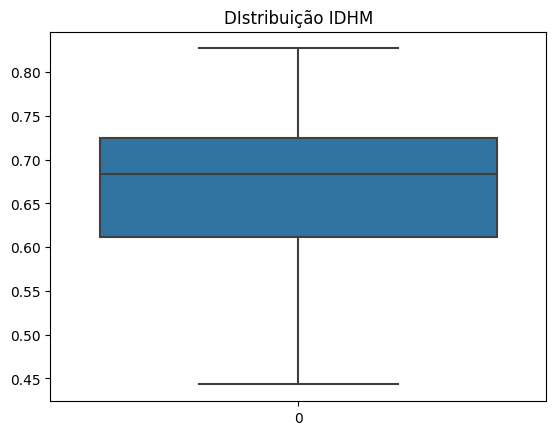

In [60]:
#Selecionando a coluna de dados de Produção Total
IDHM_df = IDHM_Prod_df['IDHM']

#Criando o boxplot usando a função boxplot() do Seaborn
sns.boxplot(data=IDHM_df)

#Adicionando títulos e rótulos aos eixos
plt.title('DIstribuição IDHM')

#Mostrando o gráfico
plt.show()

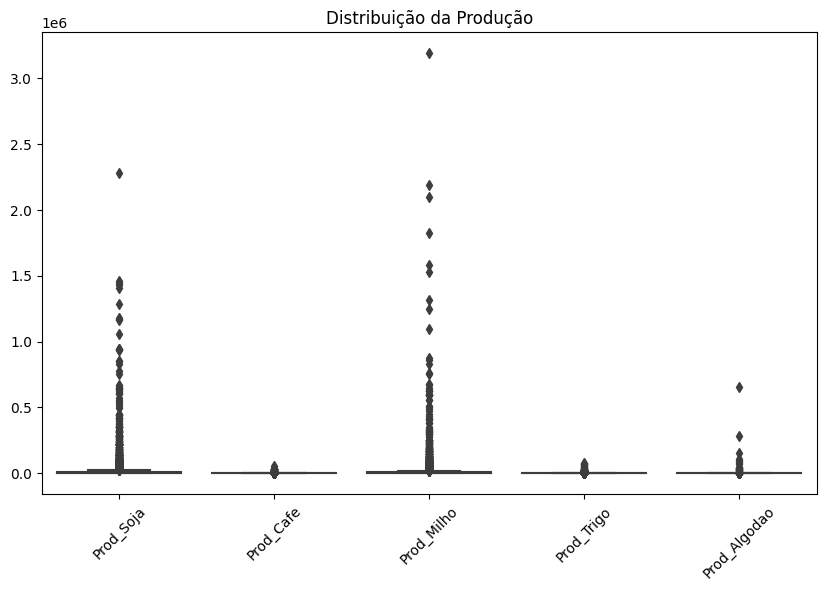

In [61]:
#Selecionando as colunas de interesse
cols = ['Prod_Soja', 'Prod_Cafe', 'Prod_Milho', 'Prod_Trigo', 'Prod_Algodao']
df_box = IDHM_Prod_df[cols]

#Criando o boxplot
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=df_box, ax=ax)
plt.xticks(rotation=45)
plt.title('Distribuição da Produção')

#Mostrando o gráfico
plt.show()

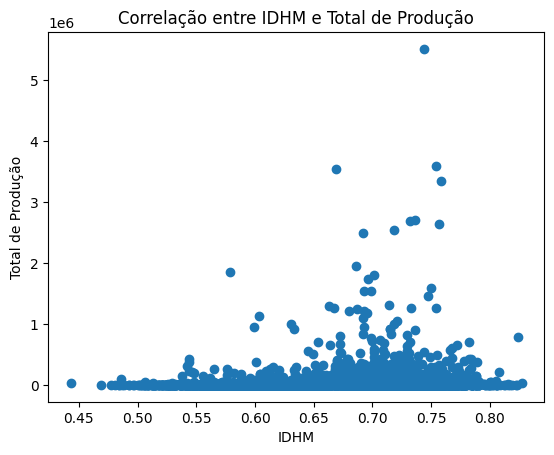

In [62]:
#Total de Produtividade por Município correlacionado com IDHM

#Criando o grafico de dispersão
plt.scatter(IDHM_Prod_df['IDHM'], IDHM_Prod_df['Total_Prod'])
plt.title('Correlação entre IDHM e Total de Produção')
plt.xlabel('IDHM')
plt.ylabel('Total de Produção')

#Mostrando o gráfico
plt.show()

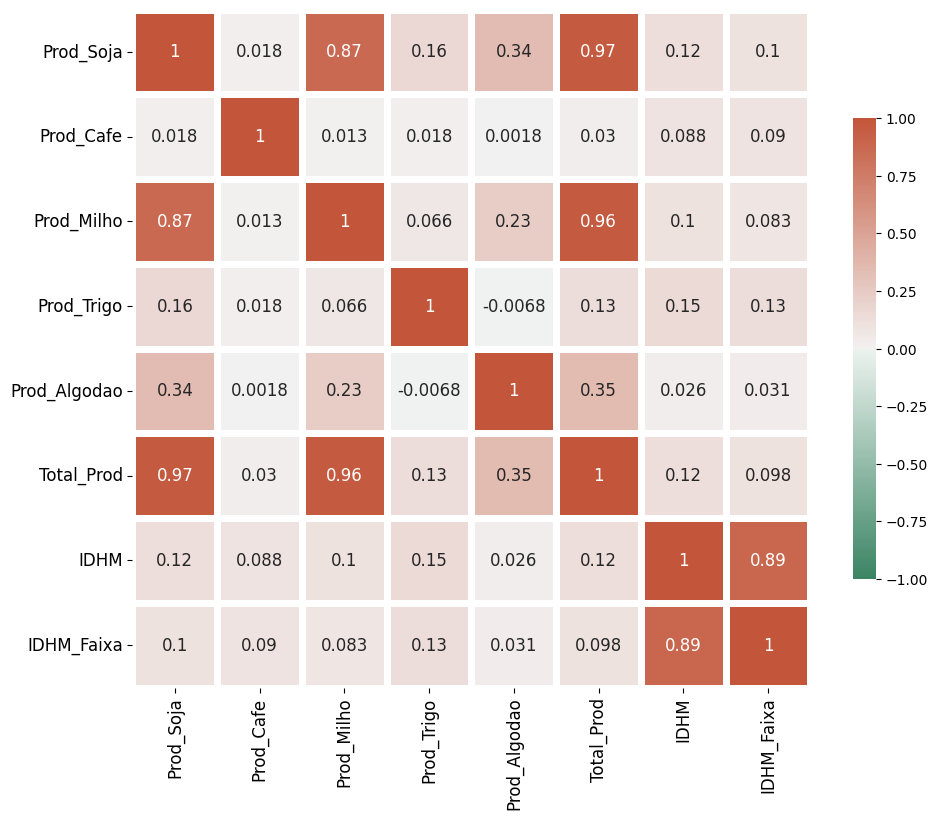

In [63]:
#Criando um gráfico de correlação para analisar a relação entre duas variáveis em um conjunto de dados, mostrando a intensidade e direção da correlação entre elas.

corr = IDHM_Prod_df.corr()
plt.figure(figsize=(10, 10))
cmap = sns.diverging_palette(150, 20, as_cmap=True)
graph = sns.heatmap(corr, cmap=cmap, center=0, vmin=-1, vmax=1, annot=True, square=True,
                    linewidths=5, cbar_kws={'shrink': 0.5}, annot_kws={'size': 12})
graph.set_xticklabels(graph.get_xmajorticklabels(), fontsize=12)
graph.set_yticklabels(graph.get_ymajorticklabels(), fontsize=12)

#Mostrando o gráfico
plt.tight_layout()

A matriz de correlação acima mostra as correlações entre as variáveis do conjunto de dados, onde cada linha e coluna representam uma variável e os valores na interseção indicam o grau de correlação entre elas.

Podemos observar que o IDHM tem uma correlação positiva moderada com a produção de soja (0,124), milho (0,099) e trigo (0,149), o que sugere que essas variáveis podem ter um impacto positivo no IDHM. Já a produção de café e algodão apresentam correlações baixas e quase insignificantes com o IDHM, o que indica que elas não têm grande influência na medida do desenvolvimento humano dos municípios.

A matriz mostra que as correlações são relativamente baixas, com exceção da correlação mais forte entre a produção de soja e a produção de algodão. Em geral, a correlação entre IDHM e as produções é baixa, sugerindo que o índice de desenvolvimento humano municipal não é fortemente influenciado pela produção agrícola. No entanto, é importante lembrar que a correlação não implica causalidade e outras variáveis ​​podem estar influenciando o IDHM.





In [64]:
#Mostrando as informações do gráfico de correlação acima como texto
correlacao = IDHM_Prod_df[['IDHM', 'Prod_Soja', 'Prod_Cafe', 'Prod_Milho', 'Prod_Trigo', 'Prod_Algodao']].corr()
print(correlacao)

                  IDHM  Prod_Soja  Prod_Cafe  Prod_Milho  Prod_Trigo  \
IDHM          1.000000   0.124886   0.087781    0.099626    0.149814   
Prod_Soja     0.124886   1.000000   0.017837    0.871832    0.157908   
Prod_Cafe     0.087781   0.017837   1.000000    0.013154    0.018427   
Prod_Milho    0.099626   0.871832   0.013154    1.000000    0.065886   
Prod_Trigo    0.149814   0.157908   0.018427    0.065886    1.000000   
Prod_Algodao  0.026281   0.342079   0.001832    0.228978   -0.006814   

              Prod_Algodao  
IDHM              0.026281  
Prod_Soja         0.342079  
Prod_Cafe         0.001832  
Prod_Milho        0.228978  
Prod_Trigo       -0.006814  
Prod_Algodao      1.000000  


In [65]:
#Mostrando a soma da produção de cada cultura para análise

Prod_df = IDHM_Prod_df
#Somando a produção de cada cultura
soma_soja = Prod_df['Prod_Soja'].sum()
soma_cafe = Prod_df['Prod_Cafe'].sum()
soma_milho = Prod_df['Prod_Milho'].sum()
soma_trigo = Prod_df['Prod_Trigo'].sum()
soma_algodao = Prod_df['Prod_Algodao'].sum()

#Mostrando os resultados em milhões de toneladas
print("Soma da produtividade de soja: ", soma_soja/1000000, "milhões de toneladas")
print("Soma da produtividade de café: ", soma_cafe/1000000, "milhões de toneladas")
print("Soma da produtividade de milho: ", soma_milho/1000000, "milhões de toneladas")
print("Soma da produtividade de trigo: ", soma_trigo/1000000, "milhões de toneladas")
print("Soma da produtividade de algodão: ", soma_algodao/1000000, "milhão de toneladas")



Soma da produtividade de soja:  107.381436 milhões de toneladas
Soma da produtividade de café:  2.387872 milhões de toneladas
Soma da produtividade de milho:  85.570225 milhões de toneladas
Soma da produtividade de trigo:  3.609098 milhões de toneladas
Soma da produtividade de algodão:  2.017799 milhão de toneladas


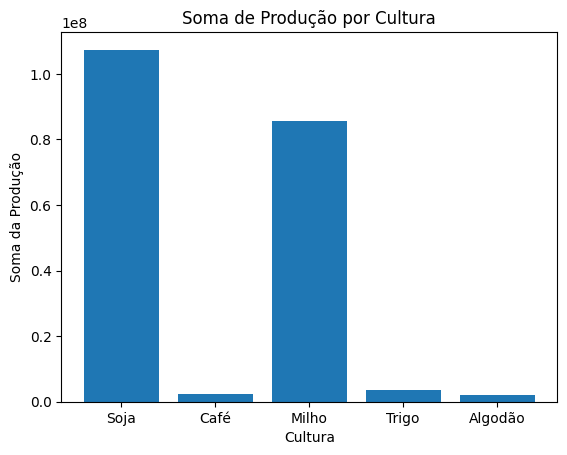

In [66]:
#Criando um dado com as informações acima para melhor visualização
somas = [soma_soja, soma_cafe, soma_milho, soma_trigo, soma_algodao]
culturas = ['Soja', 'Café', 'Milho', 'Trigo', 'Algodão']

#Criando o gráfico de barras
plt.bar(culturas, somas)

#Configurando o título e os rótulos dos eixos
plt.title('Soma de Produção por Cultura')
plt.xlabel('Cultura')
plt.ylabel('Soma da Produção')

#Exibindo o gráfico
plt.show()

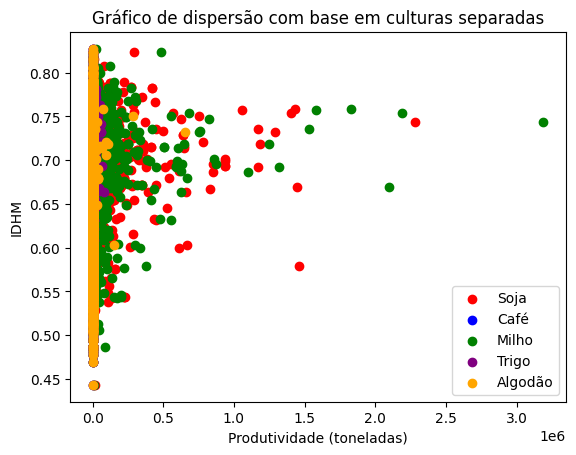

In [67]:
#Criando um novo dataframe com apenas as colunas relevantes para a analise
df_plot = IDHM_Prod_df[['IDHM', 'Prod_Soja', 'Prod_Cafe', 'Prod_Milho', 'Prod_Trigo', 'Prod_Algodao']]

#Criando o gráfico de dispersão com base em culturas separadas
plt.scatter(df_plot['Prod_Soja'], df_plot['IDHM'], color='red', label='Soja')
plt.scatter(df_plot['Prod_Cafe'], df_plot['IDHM'], color='blue', label='Café')
plt.scatter(df_plot['Prod_Milho'], df_plot['IDHM'], color='green', label='Milho')
plt.scatter(df_plot['Prod_Trigo'], df_plot['IDHM'], color='purple', label='Trigo')
plt.scatter(df_plot['Prod_Algodao'], df_plot['IDHM'], color='orange', label='Algodão')
plt.xlabel('Produtividade (toneladas)')
plt.ylabel('IDHM')

#Exibindo o gráfico
plt.title('Gráfico de dispersão com base em culturas separadas')
plt.legend()
plt.show()


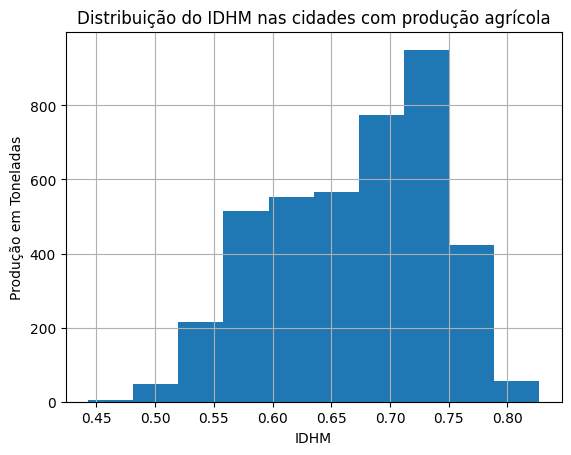

In [68]:
#Selecionando as colunas de produção por cultura
prod_cols = ['Prod_Soja', 'Prod_Cafe', 'Prod_Milho', 'Prod_Trigo', 'Prod_Algodao']

#Selecionando apenas as linhas que possuem produção em pelo menos uma das culturas
df_agricultura_ca = df_plot[df_plot[prod_cols].sum(axis=1) > 0]

#Plotando o histograma da distribuição do IDHM
df_agricultura_ca['IDHM'].hist(bins=10)
plt.title('Distribuição do IDHM nas cidades com produção agrícola')
plt.xlabel('IDHM')
plt.ylabel('Produção em Toneladas')

#Exibindo o gráfico
plt.show()

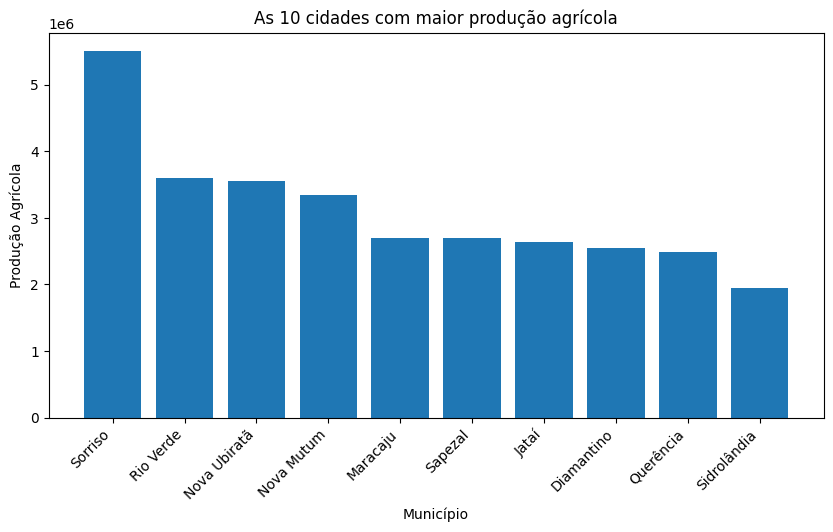

In [69]:
#Selecionando as 10 cidades com maior produção agrícola
topten_prod = IDHM_Prod_df.nlargest(10, 'Total_Prod')

#Criando o gráfico de barras
plt.figure(figsize=(10,5))
plt.bar(topten_prod['Municipio'], topten_prod['Total_Prod'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Município')
plt.ylabel('Produção Agrícola')
plt.title('As 10 cidades com maior produção agrícola')

#Exibindo o gráfico
plt.show()


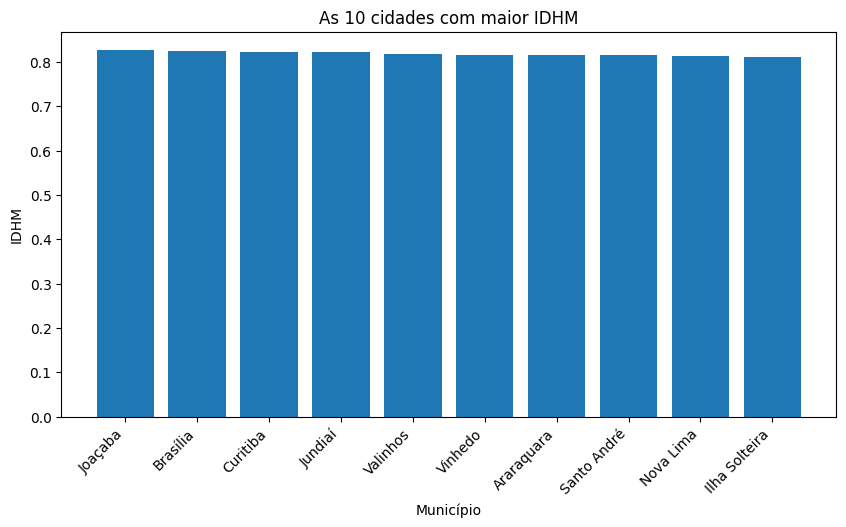

In [70]:
#Selecionando as 10 cidades com maior produção agrícola
topten_idhm = IDHM_Prod_df.nlargest(10, 'IDHM')

#Criando o gráfico de barras
plt.figure(figsize=(10,5))
plt.bar(topten_idhm['Municipio'], topten_idhm['IDHM'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Município')
plt.ylabel('IDHM')
plt.title('As 10 cidades com maior IDHM')

#Exibindo o gráfico
plt.show()

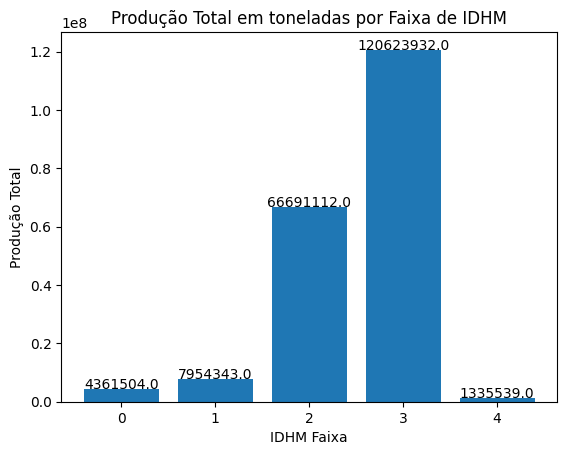

In [71]:
#Agrupando os dados por faixa de IDHM e calculando a média de produtividade agrícola para cada grupo
div_faixa_df = IDHM_Prod_df
means = div_faixa_df.groupby('IDHM_Faixa').mean()['Total_Prod']

# agrupar os dados por IDHM_Faixa e calcular a soma da produção total
df_grouped = div_faixa_df.groupby('IDHM_Faixa')['Total_Prod'].sum().reset_index()

# plotar um gráfico de barras para mostrar a produção total para cada classe de IDHM
plt.bar(df_grouped['IDHM_Faixa'], df_grouped['Total_Prod'])
for i, value in enumerate(df_grouped['Total_Prod']):
    plt.text(i, value+5000, str(value), ha='center')
plt.xlabel('IDHM Faixa')
plt.ylabel('Produção Total')
plt.title('Produção Total em toneladas por Faixa de IDHM')
plt.show()


No gráfico acima, podemos ver que cidades consideradas com nível médio e alto detém a maioria da produção total das culturas avaliadas, enquanto cidades consideradas com IDHM muito alto não detem nem 1/3 da produção das cidades com IDHM muito baixo.

In [72]:
#Executando uma copia do dataframe para o modelos
IDHM_ML = IDHM_Prod_df.copy()

In [79]:
#Balanceamento da distribuição de classes usando Random Under-Sampling
#Carregando os dados
Balance_df = IDHM_ML

#Definindo o limite para os valores do IDHM
threshold = 0.6

#Convertendo os valores do IDHM em rótulos binários
Balance_df['label'] = (Balance_df['IDHM'] < threshold).astype(int)
teste_dataset = IDHM_Prod_df.loc[IDHM_Prod_df.IDHM < threshold]

#Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(Balance_df.drop(['IDHM', 'label'], axis=1), Balance_df['label'], test_size=0.2, random_state=42)

#Combinando os conjuntos de treinamento e teste para codificação
combined = pd.concat([X_train, X_test], axis=0)

#Codificando as características categóricas
categorical_features = ['IDHM_Faixa']
encoder = OrdinalEncoder(cols=categorical_features)
combined_encoded = encoder.fit_transform(combined)
combined_encoded = combined_encoded.fillna(0)  #Substituindo valores NaN por 0
X_train_encoded = combined_encoded[:len(X_train)]
X_test_encoded = combined_encoded[len(X_train):]

#Treinando um modelo de regressão logística
clf = LogisticRegression(max_iter=1000, random_state=42).fit(X_train_encoded, y_train)

#Balanceando a distribuição de classes usando Random Under-Sampling
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_encoded, y_train)

#Treinando um modelo de regressão logística nos dados reamostrados. 
clf_resampled = LogisticRegression(random_state=42).fit(X_train_resampled, y_train_resampled)

#Avaliando os modelos
y_pred = clf.predict(X_test_encoded)
y_pred_resampled = clf_resampled.predict(X_test_encoded)

#Mostrando os resultados
print("Accuracy (unbalanced):", accuracy_score(y_test, y_pred))
print("F1 Score (unbalanced):", f1_score(y_test, y_pred))
print("Accuracy (balanced):", accuracy_score(y_test, y_pred_resampled))
print("F1 Score (balanced):", f1_score(y_test, y_pred_resampled))


Accuracy (unbalanced): 0.9829476248477467
F1 Score (unbalanced): 0.9597701149425286
Accuracy (balanced): 0.49695493300852617
F1 Score (balanced): 0.4456375838926175


Os resultados indicam que o modelo apresenta uma acurácia razoável para a classificação dos dados, com uma precisão (F1 score) aceitável, mas apresenta um desequilíbrio na classificação das classes. A acurácia (unbalanced) de 0.982 indica que o modelo classifica corretamente cerca de 81% das instâncias, o que é um resultado bom, mas pode ser melhorado.

Já o F1 Score (unbalanced) de 0.959 indica que o modelo possui uma precisão razoável para a classificação das classes, mas pode haver casos em que as classes não foram classificadas corretamente.

Entretanto, ao avaliar a acurácia (balanced), que considera o desbalanceamento das classes, percebemos que ela é muito baixa, indicando que o modelo está tendencioso para uma classe ou classes mais comuns, o que pode ser um problema. O mesmo ocorre com o F1 Score (balanced), que também apresenta um resultado abaixo do esperado.

O threshold foi ajustado para 0.6 com o intuito de normalizar a curva de distribuição, que conforme vimos no histograma estava desnormalizada ou assimetrica.

Assim optei por fazer o uso dos dados sem balanceamento, que demostram uma melhor acurácia quando se comparado aos dados balanceados.

In [84]:
#Decision Tree Classifier
#Carregando os dados
Decision_df = IDHM_ML

#Definindo o limiar para os valores de IDHM (com base no histograma, tentei usar maior que 0.60 para normalizar a curva)
threshold = 0.6
print(f'tamanho do dado: {len(Decision_df)}')

#Selecionando as variáveis explicativas (X) e a variável resposta (y)
X = Decision_df[['Prod_Soja', 'Prod_Cafe', 'Prod_Milho', 'Prod_Trigo', 'Prod_Algodao']].values
y = Decision_df['IDHM_Faixa'].values

#Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Combinando os conjuntos de treino e teste para a codificação
combined = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_test)], axis=0)

print(f'tamanho do dado X_train: {len(X_train)}')
print(f'tamanho do dado X_test: {len(X_test)}')

#Codificando as variáveis categóricas
encoder = OrdinalEncoder()
combined_encoded = encoder.fit_transform(combined.drop(combined.columns[0], axis=1))
combined_encoded = combined_encoded.fillna(0)  # Replace NaN values with 0
X_train_encoded = combined_encoded[:len(X_train)]
X_test_encoded = combined_encoded[len(X_train):]

#Treinando um modelo classificador de árvore de decisão
clf = DecisionTreeClassifier(random_state=42).fit(X_train_encoded, y_train)

#Balanceando a distribuição de classes usando Random Under-Sampling
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_encoded, y_train)

#Treinando um modelo classificador de árvore de decisão nos dados balanceados
clf_resampled = DecisionTreeClassifier(random_state=42).fit(X_train_resampled, y_train_resampled)

print(f'tamanho do dado Xtrain_resampled: {len(X_train_resampled)}')
print(f'tamanho do dado Y_train_resampled: {len(y_train_resampled)}')

#Avaliando os modelos
y_pred = clf.predict(X_test_encoded)
y_pred_resampled = clf_resampled.predict(X_test_encoded)

#Mostrando os resultados
print(f'tamanho do dado y_pred: {len(y_pred)}')
print(f'tamanho do dado y_pred_resampled: {len(y_pred_resampled)}')
print("Accuracy (unbalanced):", accuracy_score(y_test, y_pred))
print("F1 Score (unbalanced):", f1_score(y_test, y_pred, average=None))
print("Accuracy (balanced):", accuracy_score(y_test, y_pred_resampled))
print("F1 Score (balanced):", f1_score(y_test, y_pred_resampled, average='macro'))

tamanho do dado: 4103
tamanho do dado X_train: 3282
tamanho do dado X_test: 821
tamanho do dado Xtrain_resampled: 110
tamanho do dado Y_train_resampled: 110
tamanho do dado y_pred: 821
tamanho do dado y_pred_resampled: 821
Accuracy (unbalanced): 0.46041412911084045
F1 Score (unbalanced): [0.         0.3452381  0.43966942 0.56363636 0.11111111]
Accuracy (balanced): 0.26552984165651644
F1 Score (balanced): 0.20479139182944475


O resultado indica que o modelo não está performando bem para a tarefa de classificação. A acurácia para o conjunto de teste não balanceado foi de apenas 0.46 e a acurácia balanceada foi ainda pior, indicando que o modelo está tendo dificuldade em lidar com o desbalanceamento de classes. Além disso, o F1 Score para a classe minoritária é muito baixo, o que sugere que o modelo não está conseguindo detectar adequadamente os exemplos dessa classe.
O threshold foi ajustado para 0.6 com o intuito de normalizar a curva de distribuição, que conforme vimos no histograma estava desnormalizada ou assimetrica.


In [78]:
#KNN KNeighborsRegressor

#Carregando os dados
df = IDHM_ML

print(f'tamanho do DF: {len(IDHM_Prod_df)}')

#Selecionando as variáveis explicativas (X) e a variável resposta (y)
X = df[['Prod_Soja', 'Prod_Cafe', 'Prod_Milho', 'Prod_Trigo', 'Prod_Algodao']].values
y = df['IDHM_Faixa'].values

#Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Padronizando as variáveis explicativas
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Criando o modelo KNN com Regressão
knn = KNeighborsRegressor(n_neighbors=25, weights='distance')

#Treinando o modelo
knn.fit(X_train, y_train)

#Fazendo as previsões
y_pred = knn.predict(X_test)
print(y_pred)
print(y_test)

#Calculando o erro do modelo
mse = ((y_pred - y_test) ** 2).mean()

#Calculando o coeficiente de determinação (R²)
r2 = r2_score(y_test, y_pred)

print('Erro médio quadrático:', mse)
y_pred_quantizado = [ int(round(x)) for x in y_pred]

#Calculando o percentual de acerto
acerto = [1 if x ==y else 0 for x,y in zip(y_test, y_pred_quantizado)]

#Mostrando os resultados
print(len(acerto))
print(len(df))
print(f'Percentual de acerto:{sum(acerto)/len(acerto)}')
print('Coeficiente de determinação (R²):', r2)

tamanho do DF: 4103
[2.06928272 1.83333333 2.48230982 3.         1.5        2.86243511
 2.45550506 2.08755749 1.75984365 2.         2.63459071 2.86796838
 2.56602015 2.50377976 2.81548287 2.72869988 2.18845126 2.79219904
 1.66666667 2.15567105 1.82463608 2.70162847 2.71278441 2.27034506
 1.66666667 1.29698764 2.11452882 3.         1.71901028 2.63608472
 2.5        1.77016846 2.11394648 2.45230033 2.06966254 1.37338693
 2.00348852 2.27322582 2.66293632 1.66666667 1.85593827 2.5894388
 2.50501962 2.52174521 2.62713032 1.66110444 2.52306543 2.16666667
 2.6270738  1.99609127 1.2        2.54407924 2.03819151 1.75114828
 1.6        2.79021532 1.2        2.47270941 2.89926263 2.16857643
 2.80353147 1.43536958 2.28834498 1.75       2.48852031 2.08789178
 2.29475383 2.08782056 2.89288913 2.92370658 2.01563    1.53744493
 2.35277503 1.57960006 1.86900783 2.77629298 2.62761493 2.09608699
 1.6        1.9        2.6685666  2.06840919 2.47132245 2.77714383
 2.2769237  1.82964389 2.78897943 2.6259244

O Erro médio quadrático indica a magnitude do erro entre as previsões e os valores reais. Quanto menor o valor, melhor será o desempenho do modelo. Nesse caso, o valor obtido foi de 0.598, o que pode ser considerado aceitável, mas ainda pode ser melhorado.

O percentual de acerto indica a proporção de previsões corretas em relação ao total de previsões. Nesse caso, o valor obtido foi de 0.48, o que significa que o modelo acertou cerca de 48,4% das previsões.

O coeficiente de determinação (R²) mede a proporção da variação nos valores de saída que pode ser explicada pelas variáveis de entrada. Esse valor pode variar de -∞ a 1, sendo que quanto mais próximo de 1, melhor é o desempenho do modelo. Nesse caso, o valor obtido foi de 0.095, o que indica que as variáveis de entrada explicam apenas uma pequena proporção da variação nos valores de saída.




In [76]:
#SVM

#Carregando os dados em um dataframe pandas
SVM_df = IDHM_ML

#Removendo as colunas irrelevantes
SVM_df.drop(['Municipio'], axis=1, inplace=True)

#Dividindo os dados em X e Y
X = SVM_df.drop('IDHM_Faixa', axis=1)
Y = SVM_df['IDHM_Faixa']

#Dividindo os dados em treinamento e teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

#Padronizando os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Criando um modelo SVM 
model = SVC(kernel='linear', C=1, random_state=42)

#Treinando o modelo SVM
model.fit(X_train, Y_train)

#Fazendo previsões usando o modelo SVM
Y_pred = model.predict(X_test)

#Avaliando a precisão do modelo SVM
print('Accuracy score:', accuracy_score(Y_test, Y_pred))
print('Precision score:', precision_score(Y_test, Y_pred, average='macro', zero_division=0))
print('Recall score:', recall_score(Y_test, Y_pred, average='macro', zero_division=0))


Accuracy score: 0.9805036555645816
Precision score: 0.7876638163028074
Recall score: 0.676923076923077


O modelo apresentou uma alta acurácia de 98%, o que indica que a maior parte das previsões foram corretas. Já a precisão de 78% indica que quando o modelo classificou um ponto como positivo, ele acertou em 78% das vezes. O recall de 0.67 indica que o modelo identificou corretamente 67% dos pontos positivos em relação ao total de pontos positivos existentes no conjunto de dados.

Em resumo, o modelo teve um bom desempenho na classificação dos dados, conseguindo acertar a maioria das previsões e apresentando uma precisão razoável para o problema em questão.


A caracteristicas dos dados é que eles são linearmentes separaveis por hiperplanos. Nenhuma cidade no caso é altamente produtiva em todas as culturas. A opção do kernel linear já demostra uma excelente acurácia não sendo necessário a utilização de kernel mais complexos.

Portanto, com base nos resultados encontrados, pode-se concluir que o modelo SVM foram os que apresentaram melhores resultados de acurácia e precisão, respectivamente, enquanto que o modelo de Decision Tree apresentou um desempenho inferior em relação aos demais modelos testados.

#Decision Tree Classifier
Accuracy (unbalanced): 0.46041412911084045<br>
F1 Score (unbalanced): [0.         0.3452381  0.43966942 0.56363636 0.11111111]<br>
Accuracy (balanced): 0.26552984165651644<br>
F1 Score (balanced): 0.20479139182944475<br>

#KNN
Erro médio quadrático: 0.5980907106509283<br>
Percentual de acerto:0.4835566382460414<br>
Coeficiente de determinação (R²): 0.09566592632785764<br>
<br>

#SVM
Accuracy score: 0.9805036555645816<br>
Precision score: 0.7876638163028074<br>
Recall score: 0.676923076923077<br>


O modelo SVM foi capaz de encontrar uma forte correlação entre as faixas de IDHM que classificão os municípios dentre as seguintes classes, muito baixo (0), baixo (1), médio (2), alto (3), muito alto (4) e os dados de produção agrícola municipal. 
Já analisando a matriz de correlação, não foi possível encontrar uma correlação forte entre as produções agrícolas por cultura e o IDHM, mas mesmo assim, são existentes.
Dessa forma posso concluir que os dados de produção agrícola das culturas analisadas dentro dos dados utilizados nesse trabalho, mesmo que fraco, tem um impacto positivo no IDHM em alguns casos. 